## Background

In this notebook I'll work through the following prompt from the "Further Research" section of Chapter 8 (Collaborative Filtering) from the fastai textbook:

> Complete this notebook using the full MovieLens dataset, and compare your results to online benchmarks. See if you can improve your accuracy. Look on the book's website and the fast.ai forums for ideas. Note that there are more columns in the full dataset--see if you can use those too (the next chapter might give you ideas).

Here's a summary of my results in this notebook:


|Arch|Metric|Metric Value|
|:-:|:-:|:-:|
|`DotProductBias`|MSE|0.654875
|`DotProductBiasCE`|Accuracy|35%
|Random Forest (baseline)|Accuracy|29%
|Random Forest (additional columns)|Accuracy|30%|
|Neural Net|Accuracy|38%

## Load the Data

The data is formatted slightly differently than the 100k subset (main difference is the columns are labeled differently).

In [1]:
from fastai.collab import *
from fastai.tabular.all import *

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
path = Path('/content/drive/MyDrive/movielens25m')
path.ls()

(#12) [Path('/content/drive/MyDrive/movielens25m/tags.csv'),Path('/content/drive/MyDrive/movielens25m/ratings.csv'),Path('/content/drive/MyDrive/movielens25m/movies.csv'),Path('/content/drive/MyDrive/movielens25m/genome-tags.csv'),Path('/content/drive/MyDrive/movielens25m/genome-scores.csv'),Path('/content/drive/MyDrive/movielens25m/links.csv'),Path('/content/drive/MyDrive/movielens25m/README.txt'),Path('/content/drive/MyDrive/movielens25m/rf_baseline_vars.pkl'),Path('/content/drive/MyDrive/movielens25m/rf_additional_vars.pkl'),Path('/content/drive/MyDrive/movielens25m/to_nn.pkl')...]

In [4]:
ratings = pd.read_csv(path/'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [5]:
ratings['movieId'].unique().shape, ratings['userId'].unique().shape

((59047,), (162541,))

In [6]:
movies = pd.read_csv(path/'movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
movies['movieId'].unique().shape

(62423,)

In [9]:
ratings = ratings.merge(movies[['movieId', 'title']])
ratings.head()

,userId,movieId,rating,timestamp,title
0,1,296,5.0,1147880044,Pulp Fiction (1994)
1,3,296,5.0,1439474476,Pulp Fiction (1994)
2,4,296,4.0,1573938898,Pulp Fiction (1994)
3,5,296,4.0,830786155,Pulp Fiction (1994)
4,7,296,4.0,835444730,Pulp Fiction (1994)


In [ ]:
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=1024)
dls.show_batch()

,userId,title,rating
0,18382,Goldfinger (1964),3.0
1,47473,Eyes Wide Shut (1999),0.5
2,132661,Garden State (2004),3.0
3,68944,X-Men Origins: Wolverine (2009),0.5
4,126422,Animal Kingdom (2010),3.5
5,122810,Hotel Rwanda (2004),3.5
6,8458,Sherlock Holmes (2009),4.0
7,21172,Indiana Jones and the Temple of Doom (1984),4.0
8,94712,"Dark Knight, The (2008)",3.5
9,88335,Chicken Run (2000),2.0


In [ ]:
dls.classes.keys()

dict_keys(['userId', 'title'])

In [ ]:
n_users = len(dls.classes['userId'])
n_movies = len(dls.classes['title'])

n_users, n_movies

(162542, 58959)

## Training Using Different Approaches

### `DotProductBias` with `Embedding`s

The first architecture I'll use is the `DotProductBias` with `Embedding`s:

In [ ]:
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.user_bias = Embedding(n_users, 1)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.movie_bias = Embedding(n_movies, 1)
        self.y_range = y_range

    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        res = (users * movies).sum(dim=1, keepdim=True)
        res += self.user_bias(x[:,0]) + self.movie_bias(x[:,1])

        return sigmoid_range(res, *self.y_range)

I'll use the same number of epochs, learning rate and weight decay as the textbook training example:

In [ ]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.718568,0.750686,1:31:29
1,0.721771,0.743393,1:50:58
2,0.675583,0.713021,1:51:44
3,0.627697,0.671975,1:48:30
4,0.608647,0.654875,1:41:17


When using the 100k subset the lowest validation MSE I got was about 0.836. A validation MSE of 0.654875 is about a 22% reduction.

After rounding the predictions to the nearest 0.5, the model has a validation accuracy of about 30%. Yikes! That's terrible.

In [ ]:
preds, targs = learn.get_preds(dl=dls.valid)

In [ ]:
preds

tensor([[3.1825],
        [3.1959],
        [3.6061],
        ...,
        [1.6408],
        [3.3054],
        [3.4723]])

In [ ]:
rounded_preds = (preds / 0.5).round() * 0.5
rounded_preds

tensor([[3.0000],
        [3.0000],
        [3.5000],
        ...,
        [1.5000],
        [3.5000],
        [3.5000]])

In [ ]:
targs

tensor([[3.0000],
        [5.0000],
        [3.5000],
        ...,
        [1.0000],
        [2.0000],
        [3.5000]])

In [ ]:
(rounded_preds == targs).float().mean()

tensor(0.2931)

If I round to the nearest integer, the validation accuracy increases to about 36%. Still not great.

In [ ]:
(preds.round(decimals=0) == targs).float().mean()

tensor(0.3581)

Plotting predictions versus the targets shows the weak relationship between the two:

In [ ]:
def plot_preds_v_targs(preds, targs):
  plt.figure(figsize=(10, 6))
  plt.scatter(targs.detach().numpy().squeeze(), preds.detach().numpy().squeeze(), alpha=0.5)
  plt.xlabel('Targets')
  plt.ylabel('Predictions')
  plt.title('Predictions vs Targets')
  plt.show()

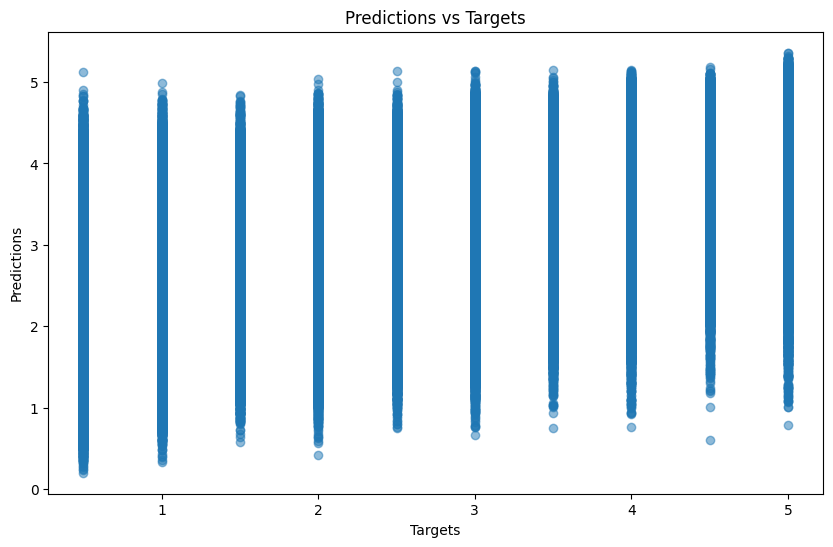

In [ ]:
plot_preds_v_targs(preds, targs)

Here's the distribution of the ratings targets for the ~5M validation records:

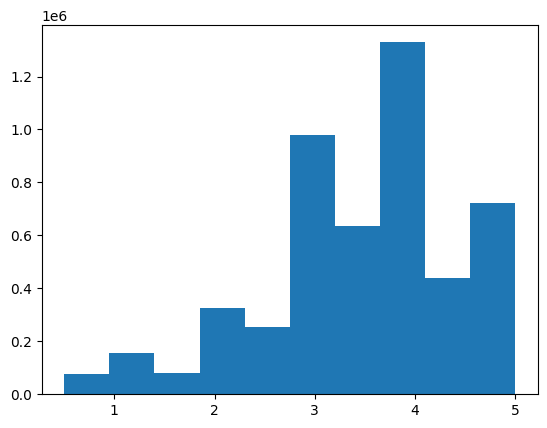

In [ ]:
plt.hist(targs.detach().numpy().squeeze());

There are considerably fewer predictions less than 3 and greater than 4:

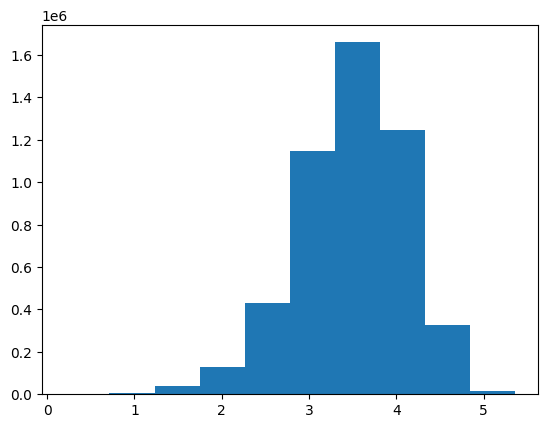

In [ ]:
plt.hist(preds.detach().numpy().squeeze());

Let's hope for better luck with other architectures!

### `DotProductBiasCE` (for Cross Entropy Loss)

I'll use the same architecture that I created for another Further Research prompt, with the slight modification that instead of projecting the dot product to 5 ratings I'll project them to 10 ratings (as there are ten 0.5-increment ratings in the dataset: 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0).

In [ ]:
class DotProductBiasCE(Module):
  def __init__(self, n_users, n_movies, n_factors):
    self.user_factors = Embedding(n_users, n_factors)
    self.user_bias = Embedding(n_users, 1)
    self.movie_factors = Embedding(n_movies, n_factors)
    self.movie_bias = Embedding(n_movies, 1)
    self.linear = nn.Linear(1, 10)

  def forward(self, x_cat, x_cont):
    x = x_cat
    users = self.user_factors(x[:,0])
    movies = self.movie_factors(x[:,1])
    res = (users * movies).sum(dim=1, keepdim=True)
    res += self.user_bias(x[:,0]) + self.movie_bias(x[:,1])
    return self.linear(res)

I'll use the same training setup as I did with the 100k subset, but with a larger batch size (otherwise it takes much longer to train). Note that using the same learning rate for a batch size of 1024 as a batch size of 64 will likely not result in optimal training.

In [ ]:
dls = TabularDataLoaders.from_df(
    ratings[['userId', 'title', 'rating']],
    procs=[Categorify],
    cat_names=['userId','title'],
    y_names=['rating'],
    y_block=CategoryBlock,
    bs=1024)

In [ ]:
b = dls.one_batch()
len(b), b[0].shape, b[1].shape, b[2].shape

(3, torch.Size([1024, 2]), torch.Size([1024, 0]), torch.Size([1024, 1]))

In [ ]:
dls.vocab

[0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]

In [ ]:
dls.show_batch()

,userId,title,rating
0,64415,Jumpin' Jack Flash (1986),2.0
1,10508,"Lord of the Rings: The Return of the King, The (2003)",4.5
2,126649,Frances Ha (2012),4.0
3,119566,Elizabeth (1998),3.0
4,77160,Snake Eyes (1998),5.0
5,99259,"Untouchables, The (1987)",3.5
6,3726,"Myth of Fingerprints, The (1997)",2.0
7,100959,Meet the Parents (2000),3.5
8,134993,"Nightmare on Elm Street, A (1984)",1.0
9,117798,Doubt (2008),4.0


In [ ]:
n_users = len(dls.classes['userId'])
n_movies = len(dls.classes['title'])

n_users, n_movies

(162542, 58959)

Training with Cross Entropy Loss on the 25M dataset resulted in a model with about 35% validation accuracy, about 6% less than the 41% achieved on the 100k subset. The model is not showing signs of overfitting so I could have trained it for more epochs and potentially gained more accuracy.

In [ ]:
model = DotProductBiasCE(n_users, n_movies, n_factors=50)
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
learn.fit_one_cycle(5, 0.1, wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,1.919933,1.924016,0.288326,1:04:57
1,1.914961,1.927970,0.284413,1:33:05
2,1.900328,1.901067,0.294077,1:19:56
3,1.837524,1.847121,0.313432,1:40:26
4,1.704779,1.740781,0.354360,1:18:08


3's and 4's were the most correctly predicted ratings by this model, with the model performing quite badly for other ratings---in particular, the model did not predict any 0.5, 1.5, 2.5, 3.5, or 4.5 ratings.

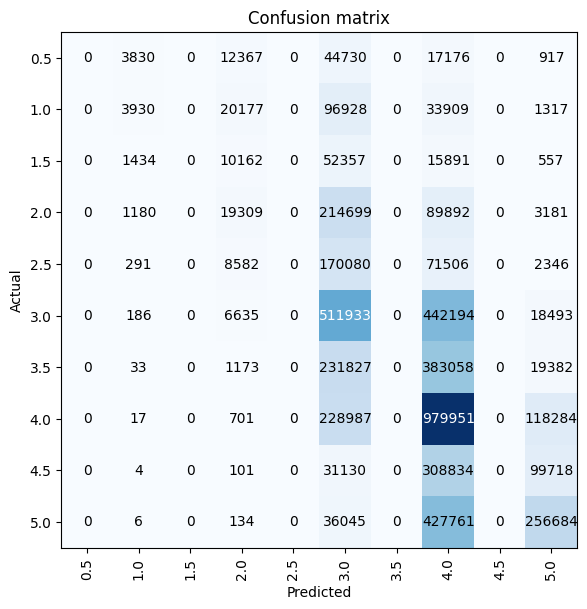

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(6, 6))

In [ ]:
preds, targs = learn.get_preds(dl=learn.dls.valid)

By far the most common predicted rating was 4.0 (the 7th category in the vocab). Again, I'll note the gaps between the bars where the 0.5-increment ratings are absent from the model's predictions.

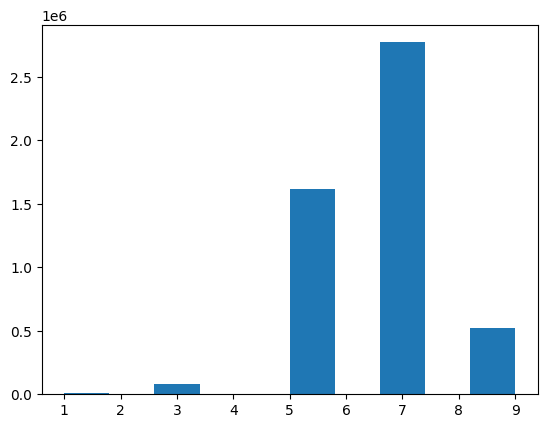

In [ ]:
plt.hist(preds.argmax(dim=1));

While the most common target is also 4.0, note that it's frequency is about half that in the prediction distribution.

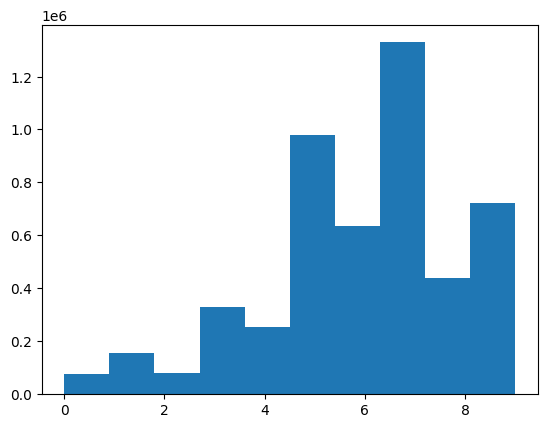

In [ ]:
plt.hist(targs.squeeze());

### Random Forest (baseline)

As an additional exercise I'll train a random forest on the `userId`, `movieId` and `rating` fields. In the following section, I'll add some of the additional fields available and see if that improves the forest's performance. I'll follow the approach given in [Chapter 9 of the fastai textbook](https://github.com/fastai/fastbook/blob/master/09_tabular.ipynb).

#### Setup

I'll start by creating a `TabularPandas` object with a random split:

In [10]:
splits = RandomSplitter(seed=42)(range_of(ratings))

In [11]:
len(splits), len(splits[0]), len(splits[1])

(2, 20000076, 5000019)

In [12]:
to = TabularPandas(
    ratings[['userId', 'title', 'rating']],
    procs=[Categorify, FillMissing],
    cat_names=['userId', 'title'],
    cont_names=None,
    y_names='rating',
    y_block=CategoryBlock,
    splits=splits)

In [13]:
len(to.train), len(to.valid)

(20000076, 5000019)

In [14]:
to.show(3)

,userId,title,rating
8613915,11056,Divergent (2014),2.0
20221395,128803,"Town, The (2010)",4.0
21140474,56442,Jack Ryan: Shadow Recruit (2014),3.0


In [15]:
to.items.head(3) # coded values

,userId,title,rating
8613915,11056,13670,3
20221395,128803,53868,7
21140474,56442,24434,5


In [16]:
to.vocab # 10 possible ratings

[0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]

In [17]:
# defining variables
xs,y = to.train.xs, to.train.y
valid_xs,valid_y = to.valid.xs, to.valid.y

xs.shape, y.shape, valid_xs.shape, valid_y.shape

((20000076, 2), (20000076,), (5000019, 2), (5000019,))

In [18]:
#save_pickle(path/'rf_baseline_vars.pkl', (xs, y, valid_xs, valid_y))

I'll create helper functions to calculate accuracy of the model:

In [4]:
def acc(pred,y): return (pred == y).mean()
def m_acc(m, xs, y): return acc(m.predict(xs), y)

In [5]:
from sklearn.ensemble import RandomForestClassifier

def rf(xs, y, n_estimators=4, max_samples=10_000, max_features=0.5,
       min_samples_leaf=5, **kwargs):
  return RandomForestClassifier(n_jobs=-1, n_estimators=n_estimators, max_samples=max_samples,
              max_features=max_features, min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

#### Training Results

Since training on the full data will likely take awhile, I'll first fit a random forest with 4 trees and a max of ten thousand samples for each tree, which takes about a minute to train and results in a 22% validation accuracy which is not bad!

In [21]:
m = rf(xs, y, n_estimators=4, max_samples=10_000)

In [22]:
m_acc(m, xs, y), m_acc(m, valid_xs, valid_y)

(0.22450199689241182, 0.22447194700660136)

Doubling the number of trees (to `8`) increases the validation accuracy to 24% (+2%).

In [23]:
m = rf(xs, y, n_estimators=8, max_samples=10_000)
m_acc(m, xs, y), m_acc(m, valid_xs, valid_y)

(0.24051508604267305, 0.24045988625243225)

Tripling the number of trees (to `12`) gives a smaller boost (1%) to the validation accuracy (25%).

In [24]:
m = rf(xs, y, n_estimators=12, max_samples=10_000)
m_acc(m, xs, y), m_acc(m, valid_xs, valid_y)

(0.25057739780588834, 0.25026804898141386)

As the number of samples increases by `10_000` (while keeping `n_estimators=4`) the validation accuracy increases by about 0.2-0.5% each time.

In [12]:
for samples in [20_000, 30_000, 40_000]:
  m = rf(xs, y, n_estimators=4, max_samples=samples)
  print(f'samples: {samples}; train acc: {m_acc(m, xs, y)}; valid acc: {m_acc(m, valid_xs, valid_y)}')

samples: 20000; train acc: 0.23020222523154413; valid acc: 0.22950612787671407
samples: 30000; train acc: 0.23159146995241417; valid acc: 0.2313785207616211
samples: 40000; train acc: 0.23347261280407133; valid acc: 0.23300171459348454


Next, I'll train a random forest using the parameters given in Chapter 9 of the text (`40` trees, `200_000` samples), keeping in mind that was for a 400k row dataset, so not optimized for 25M rows of data. I'll then double `n_estimators` and `max_samples` to see which combination works best. I'm not using a for-loop like above since my Colab instance kept crashing so I'll fit the different random forests in individual cells.

`40` trees and `200_000` samples results in a validation accuracy of 28% (+3% from the previous best achieved by `12` trees and `10_000` samples).

In [13]:
trees = 40
samples = 200_000
m = rf(xs, y, n_estimators=trees, max_samples=samples)
print(f'samples: {samples}; trees: {trees}; train acc: {m_acc(m, xs, y):.2f}; valid acc: {m_acc(m, valid_xs, valid_y):.2f}')

samples: 200000; trees: 40; train acc: 0.29; valid acc: 0.28


Doubling the number of trees from `40` to `80` results in a 29% validation accuracy (+1%). It took about 35 minutes to train and predict.

In [8]:
trees = 80
samples = 200_000
m = rf(xs, y, n_estimators=trees, max_samples=samples)
print(f'samples: {samples}; trees: {trees}; train acc: {m_acc(m, xs, y):.2f}; valid acc: {m_acc(m, valid_xs, valid_y):.2f}')

samples: 200000; trees: 80; train acc: 0.29; valid acc: 0.29


Doubling the number of samples used to `400_000` while keeping the number of trees at `40` achieves the same validation accuracy (29%) and took about 21 minutes for training and inference.

In [7]:
trees = 40
samples = 400_000
m = rf(xs, y, n_estimators=trees, max_samples=samples)
print(f'samples: {samples}; trees: {trees}; train acc: {m_acc(m, xs, y):.2f}; valid acc: {m_acc(m, valid_xs, valid_y):.2f}')

samples: 400000; trees: 40; train acc: 0.30; valid acc: 0.29


Doubling the number of trees to `80` with `400_000` samples achieves the same accuracy of 29% (while taking 42 minutes for training and inference).

In [7]:
trees = 80
samples = 400_000
m = rf(xs, y, n_estimators=trees, max_samples=samples)
print(f'samples: {samples}; trees: {trees}; train acc: {m_acc(m, xs, y):.2f}; valid acc: {m_acc(m, valid_xs, valid_y):.2f}')

samples: 400000; trees: 80; train acc: 0.30; valid acc: 0.29


I'll increase the number of samples significantly to `2_000_000`. I'll keep the number of trees at `40` for now since increasing that number doesn't seem to improve validation accuracy significantly.

This results in a validation accuracy of 29%.

It doesn't seem like increasing the number of trees or samples will significantly change the validation accuracy.

In [7]:
trees = 40
samples = 2_000_000
m = rf(xs, y, n_estimators=trees, max_samples=samples)
print(f'samples: {samples}; trees: {trees}; train acc: {m_acc(m, xs, y):.2f}; valid acc: {m_acc(m, valid_xs, valid_y):.2f}')

samples: 2000000; trees: 40; train acc: 0.33; valid acc: 0.29


In [6]:
def rf_feat_importance(m, df):
  return pd.DataFrame({'cols': df.columns, 'imp': m.feature_importances_}
                      ).sort_values('imp', ascending=False)

With this data and model, `userId` is almost twice as important as the movie `title`.

In [9]:
rf_feat_importance(m, xs)

,cols,imp
0,userId,0.640407
1,title,0.359593


### Random Forest (with additional data)

There a few additional columns available that may improve the performance of the random forest:

- `ratings.csv` has a `timestamp` column.
  - This is easy to incorporate as there is one value per rating.
- `movies.csv` has a `genres` column.
  - There are multiple pipe-separated genres per movie, I'll pick one genre per movie.
- `tags.csv` has tags associated with each movie by users.
  - There are multiple tags for each movie/user pair, I'll pick one tag per user/movie pair.
- `genome-scores.csv` has `genome-tags` associated with each movie.
  - There are multiple genome-tags per movie, so I'll pick the genome-tag with the highest score for each movie.

In [8]:
# do str.split on `movies` before merging with `ratings` since it has fewer rows
movies['genres'] = movies['genres'].str.split('|', n=1).str[0]

In [9]:
ratings = ratings.merge(movies)

In [10]:
ratings.head() # peep the new `genres` column with a single genre

,userId,movieId,rating,timestamp,title,genres
0,1,296,5.0,1147880044,Pulp Fiction (1994),Comedy
1,3,296,5.0,1439474476,Pulp Fiction (1994),Comedy
2,4,296,4.0,1573938898,Pulp Fiction (1994),Comedy
3,5,296,4.0,830786155,Pulp Fiction (1994),Comedy
4,7,296,4.0,835444730,Pulp Fiction (1994),Comedy


In [11]:
ratings.shape

(25000095, 6)

Only a fraction (~10%) of all of the `ratings.csv` `userId`s are captured in `tags.csv`, whereas about 75% of the `movieId`s are captured in `tags.csv`. I'll pick the most frequent tag for each movie and merge with the `ratings` data.

In [12]:
tags = pd.read_csv(path/'tags.csv')

In [13]:
ratings['userId'].unique().shape, tags['userId'].unique().shape

((162541,), (14592,))

In [14]:
ratings['movieId'].unique().shape, tags['movieId'].unique().shape

((59047,), (45251,))

There's about 8k tags that are different only because of capitalization---I'll set all tags to lower case:

In [15]:
tags['tag'].unique().shape, tags['tag'].str.lower().unique().shape

((73051,), (65465,))

In [16]:
tags['tag'] = tags['tag'].str.lower()

In [17]:
# thanks Claude 3.5 Sonnet
# this was MUCH faster than using groupby + agg
most_common_tags = (
    tags.groupby(['movieId', 'tag'])
    .size()
    .reset_index(name='count')
    .sort_values(['movieId', 'count'], ascending=[True, False])
    .drop_duplicates('movieId')
    .drop('count', axis=1)
)

most_common_tags.head()

,movieId,tag
78,1,pixar
155,2,robin williams
168,3,fishing
185,4,chick flick
207,5,steve martin


In [18]:
ratings.shape

(25000095, 6)

In [19]:
ratings = ratings.merge(most_common_tags, on=['movieId'], how='left')
print(ratings.shape)
ratings.head()

(25000095, 7)


,userId,movieId,rating,timestamp,title,genres,tag
0,1,296,5.0,1147880044,Pulp Fiction (1994),Comedy,quentin tarantino
1,3,296,5.0,1439474476,Pulp Fiction (1994),Comedy,quentin tarantino
2,4,296,4.0,1573938898,Pulp Fiction (1994),Comedy,quentin tarantino
3,5,296,4.0,830786155,Pulp Fiction (1994),Comedy,quentin tarantino
4,7,296,4.0,835444730,Pulp Fiction (1994),Comedy,quentin tarantino


Only a very small fraction of ratings are without a tag:

In [20]:
ratings['tag'].isna().sum()

83417

In [21]:
genome_scores = pd.read_csv(path/'genome-scores.csv')

In [22]:
genome_tags = pd.read_csv(path/'genome-tags.csv')

In [23]:
genome_scores.head()

,movieId,tagId,relevance
0,1,1,0.02875
1,1,2,0.02375
2,1,3,0.06250
3,1,4,0.07575
4,1,5,0.14075


In [24]:
genome_tags.head()

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


I'll use the most relevant genome tag for each movie:

In [25]:
most_common_genomes = (
    genome_scores.sort_values(['movieId', 'relevance'], ascending=[True, False])
    .drop_duplicates('movieId')
)

most_common_genomes.head()

,movieId,tagId,relevance
1035,1,1036,0.99925
1156,2,29,0.97600
3156,3,901,0.97525
4499,4,1116,0.97525
5412,5,901,0.96025


In [26]:
genome_scores['movieId'].unique().shape, most_common_genomes.shape

((13816,), (13816, 3))

With that sorted, I'll get the actual tag text:

In [27]:
most_common_genomes = most_common_genomes.merge(genome_tags)
most_common_genomes.shape

(13816, 4)

In [28]:
most_common_genomes = most_common_genomes.rename(columns={'tag': 'genome_tag'})
most_common_genomes.head()

,movieId,tagId,relevance,genome_tag
0,1,1036,0.99925,toys
1,1920,1036,0.99575,toys
2,3114,1036,0.99850,toys
3,78499,1036,0.99875,toys
4,81981,1036,0.84225,toys


In [29]:
most_common_genomes['movieId'].unique().shape

(13816,)

and add it to the main `DataFrame`:

In [30]:
ratings.shape

(25000095, 7)

In [31]:
ratings = ratings.merge(most_common_genomes[['movieId', 'genome_tag']], how='left')
ratings.head()

,userId,movieId,rating,timestamp,title,genres,tag,genome_tag
0,1,296,5.0,1147880044,Pulp Fiction (1994),Comedy,quentin tarantino,hit men
1,3,296,5.0,1439474476,Pulp Fiction (1994),Comedy,quentin tarantino,hit men
2,4,296,4.0,1573938898,Pulp Fiction (1994),Comedy,quentin tarantino,hit men
3,5,296,4.0,830786155,Pulp Fiction (1994),Comedy,quentin tarantino,hit men
4,7,296,4.0,835444730,Pulp Fiction (1994),Comedy,quentin tarantino,hit men


With the `DataFrame` established, I'll create a `TabularPandas` object using the same seed (`42`) as before for `splits`.

In [32]:
splits = RandomSplitter(seed=42)(range_of(ratings))
len(splits), len(splits[0]), len(splits[1])

(2, 20000076, 5000019)

In [33]:
to = TabularPandas(
    ratings[['userId', 'title', 'timestamp', 'genres', 'tag', 'genome_tag', 'rating']],
    procs=[Categorify, FillMissing],
    cat_names=['userId', 'title', 'genres', 'tag', 'genome_tag'],
    cont_names=['timestamp'],
    y_names='rating',
    y_block=CategoryBlock,
    splits=splits)

In [34]:
len(to.train), len(to.valid)

(20000076, 5000019)

In [35]:
to.show(3)

,userId,title,genres,tag,genome_tag,timestamp,rating
8613915,11056,Divergent (2014),Adventure,dystopia,vampire human love,1422282990,2.0
20221395,128803,"Town, The (2010)",Crime,ben affleck,crime,1312046717,4.0
21140474,56442,Jack Ryan: Shadow Recruit (2014),Action,cia,tom clancy,1491438306,3.0


In [36]:
to.items.head(3) # coded values

,userId,title,timestamp,genres,tag,genome_tag,rating
8613915,11056,13670,1422282990,3,4536,791,3
20221395,128803,53868,1312046717,7,1983,183,7
21140474,56442,24434,1491438306,2,3241,769,5


In [37]:
xs,y = to.train.xs, to.train.y
valid_xs,valid_y = to.valid.xs, to.valid.y

xs.shape, y.shape, valid_xs.shape, valid_y.shape

((20000076, 6), (20000076,), (5000019, 6), (5000019,))

Using the additional columns has increased the validation accuracy from 22% (when using only `movieId` and `userId`) to 23.7% (when using the additional columns `timestamp`, `tag`, `genome_tag` and `genres`).

In [9]:
m = rf(xs, y, n_estimators=4, max_samples=10_000)
m_acc(m, xs, y), m_acc(m, valid_xs, valid_y)

(0.23697224950545187, 0.23664510074861717)

Doubling the number of trees to `8` yields a validation accuracy of 25% (a ~1% increase from before).

In [10]:
m = rf(xs, y, n_estimators=8, max_samples=10_000)
m_acc(m, xs, y), m_acc(m, valid_xs, valid_y)

(0.2500907496551513, 0.24987865046112825)

Tripling the number of trees to `12` yields a validation accuracy of 26% (a ~1% increase from before).

In [11]:
m = rf(xs, y, n_estimators=12, max_samples=10_000)
m_acc(m, xs, y), m_acc(m, valid_xs, valid_y)

(0.25923971488908343, 0.2590440156327406)

For every `10_000` sample increase (with `4` trees) the validation accuracy improves between 0.02-0.6%.

In [7]:
for samples in [20_000, 30_000, 40_000]:
  m = rf(xs, y, n_estimators=4, max_samples=samples)
  print(f'samples: {samples}; train acc: {m_acc(m, xs, y)}; valid acc: {m_acc(m, valid_xs, valid_y)}')

samples: 20000; train acc: 0.24337092519048428; valid acc: 0.24275807751930542
samples: 30000; train acc: 0.2467036625260824; valid acc: 0.24597866528107193
samples: 40000; train acc: 0.24714531084781877; valid acc: 0.24619486445951505


Increasing the number of trees to `40` and the number of samples to `200_000` results in a validation accuracy of 30% (the baseline random forest validation accuracy was 28%).

In [10]:
trees = 40
samples = 200_000
m = rf(xs, y, n_estimators=trees, max_samples=samples)
print(f'samples: {samples}; trees: {trees}; train acc: {m_acc(m, xs, y):.2f}; valid acc: {m_acc(m, valid_xs, valid_y):.2f}')

samples: 200000; trees: 40; train acc: 0.30; valid acc: 0.30


Doubling the number of trees results in a validation accuracy of 30%. (baseline was 29%).

In [12]:
trees = 80
samples = 200_000
m = rf(xs, y, n_estimators=trees, max_samples=samples)
print(f'samples: {samples}; trees: {trees}; train acc: {m_acc(m, xs, y):.2f}; valid acc: {m_acc(m, valid_xs, valid_y):.2f}')

samples: 200000; trees: 80; train acc: 0.31; valid acc: 0.30


Doubling the number of samples to `400_000` with `40` trees gets a validation accuracy of 30% (baseline was 29%).

In [14]:
trees = 40
samples = 400_000
m = rf(xs, y, n_estimators=trees, max_samples=samples)
print(f'samples: {samples}; trees: {trees}; train acc: {m_acc(m, xs, y):.2f}; valid acc: {m_acc(m, valid_xs, valid_y):.2f}')

samples: 400000; trees: 40; train acc: 0.31; valid acc: 0.30


Doubling the number of trees to `80` with `400_000` samples does not improve the validation accuracy of 30%.

In [16]:
trees = 80
samples = 400_000
m = rf(xs, y, n_estimators=trees, max_samples=samples)
print(f'samples: {samples}; trees: {trees}; train acc: {m_acc(m, xs, y):.2f}; valid acc: {m_acc(m, valid_xs, valid_y):.2f}')

samples: 400000; trees: 80; train acc: 0.32; valid acc: 0.30


Even after increasing the number of samples to 2M, the validation accuracy stays at 30%.

In [9]:
trees = 40
samples = 2_000_000
m = rf(xs, y, n_estimators=trees, max_samples=samples)
print(f'samples: {samples}; trees: {trees}; train acc: {m_acc(m, xs, y):.2f}; valid acc: {m_acc(m, valid_xs, valid_y):.2f}')

samples: 2000000; trees: 40; train acc: 0.36; valid acc: 0.30


It's interesting (and a bit concerning) to note that `timestamp` is the most important feature for this model---it's 6-7 times as important as the movie `title`.

In [10]:
rf_feat_importance(m, xs)

,cols,imp
5,timestamp,0.443988
0,userId,0.346306
1,title,0.073165
3,tag,0.060231
4,genome_tag,0.056996
2,genres,0.019314


I'll follow fastai's Chapter 9 approach to determining which columns' values differ the most between the training and validation set.

In [11]:
df_dom = pd.concat([xs, valid_xs])
is_valid = np.array([0]*len(xs) + [1]*len(valid_xs))

In [12]:
m = rf(df_dom, is_valid, n_estimators=40, max_samples=400_000)

`timestamp` is the most important feature when distinguishing between the training and validation set. I'll remove it to see if it improves training.

In [13]:
rf_feat_importance(m, df_dom)

,cols,imp
5,timestamp,0.313090
0,userId,0.311026
1,title,0.131196
3,tag,0.106029
4,genome_tag,0.099509
2,genres,0.039150


In [14]:
m = rf(xs.drop('timestamp', axis=1), y, n_estimators=40, max_samples=400_000)

After removing `timestamp`, `userId` surges to the top, being 6 times as important as the 2nd-most important feature (`title`). The validation accuracy stays at 30%.

In [15]:
rf_feat_importance(m, xs.drop('timestamp', axis=1))

,cols,imp
0,userId,0.674746
1,title,0.113734
3,tag,0.096440
4,genome_tag,0.088569
2,genres,0.026510


In [18]:
m_acc(m, valid_xs.drop('timestamp', axis=1), valid_y)

0.2971844706990113

### Neural Net (`tabular_learner`)

Next, I'll train a neural net on this data and see how it performs. I'll also use the embeddings from the neural net later on to train a new random forest.

In [5]:
df_nn = ratings.drop(['timestamp', 'movieId'], axis=1)

In [7]:
df_nn.head()

,userId,rating,title,genres,tag,genome_tag
0,1,5.0,Pulp Fiction (1994),Comedy,quentin tarantino,hit men
1,3,5.0,Pulp Fiction (1994),Comedy,quentin tarantino,hit men
2,4,4.0,Pulp Fiction (1994),Comedy,quentin tarantino,hit men
3,5,4.0,Pulp Fiction (1994),Comedy,quentin tarantino,hit men
4,7,4.0,Pulp Fiction (1994),Comedy,quentin tarantino,hit men


In [9]:
procs_nn = [Categorify, FillMissing]
cat_nn = ['userId', 'genres', 'tag', 'genome_tag']
cont_nn = None
splits = RandomSplitter(seed=42)(range_of(df_nn))
len(splits), len(splits[0]), len(splits[1])

(2, 20000076, 5000019)

In [10]:
to_nn = TabularPandas(
    df_nn,
    procs_nn,
    cat_names=cat_nn,
    cont_names=None,
    splits=splits,
    y_names='rating',
    y_block=CategoryBlock)

In [5]:
dls = to_nn.dataloaders(1024)

In [6]:
dls.show_batch()

,userId,genres,tag,genome_tag,rating
0,149149,Documentary,boxing,documentary,4.0
1,5588,Action,conspiracy,conspiracy,5.0
2,67949,Adventure,animation,computer animation,3.0
3,61069,Action,satire,satire,0.5
4,43620,Comedy,1930s,1930s,3.0
5,161519,Action,natalie portman,hit men,4.0
6,155206,Crime,tom hanks,oscar (best directing),4.0
7,91508,Drama,england,skinhead,4.0
8,76347,Drama,clint eastwood,western,5.0
9,30987,Crime,serial killer,oscar (best directing),5.0


In [6]:
learn = tabular_learner(dls, layers=[1000, 500], loss_func=CrossEntropyLossFlat(), metrics=accuracy)

SuggestedLRs(valley=0.0003311311302240938)

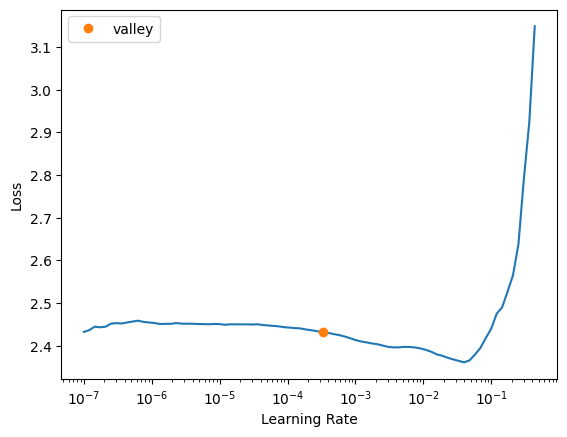

In [11]:
learn.lr_find()

The GPU RAM stayed at around 3.5/15.0 GB during training so if I wanted to train again I'd use a larger batch size. The neural net achieved a 38% validation accuracy, better than the random forest (30%) and the `DotProductBiasCE` model (35%).

In [12]:
learn.fit_one_cycle(5, 2e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.576747,1.615499,0.359292,19:06
1,1.557086,1.605259,0.362625,18:48
2,1.514029,1.582966,0.369193,19:03
3,1.422227,1.559873,0.377868,18:50
4,1.328115,1.570342,0.382583,18:48


The neural net is much better at predicting a diverse range of ratings (whereas `DotProductBiasCE` did not predict any ratings ending with `.5`). Like the `DotProductBiasCE` model, the neural net's most accurate prediction was `4`. Unlike `DotProductBiasCE` the diagonal in the confusion matrix is somewhat darker than the non-diagonal, showing that the model is doing a better job of correctly predicting ratings (as exhibited by the higher overall accuracy).

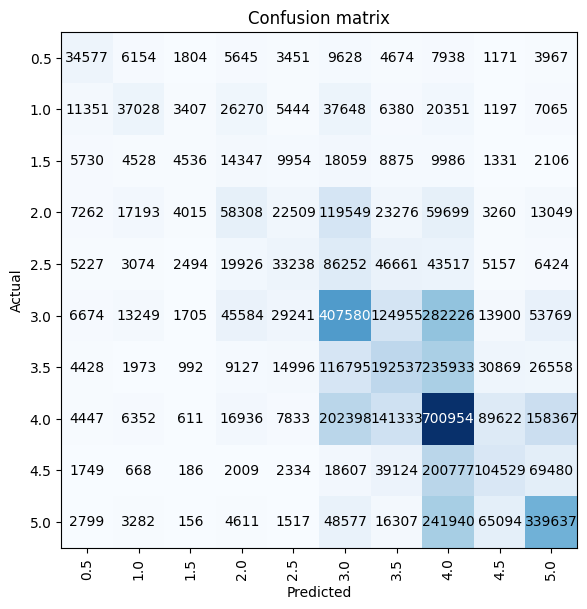

In [13]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(6, 6))

In [9]:
preds, targs = learn.get_preds(dl=learn.dls.valid)

The distribution of predictions has no gaps---the model predicts all possible ratings.

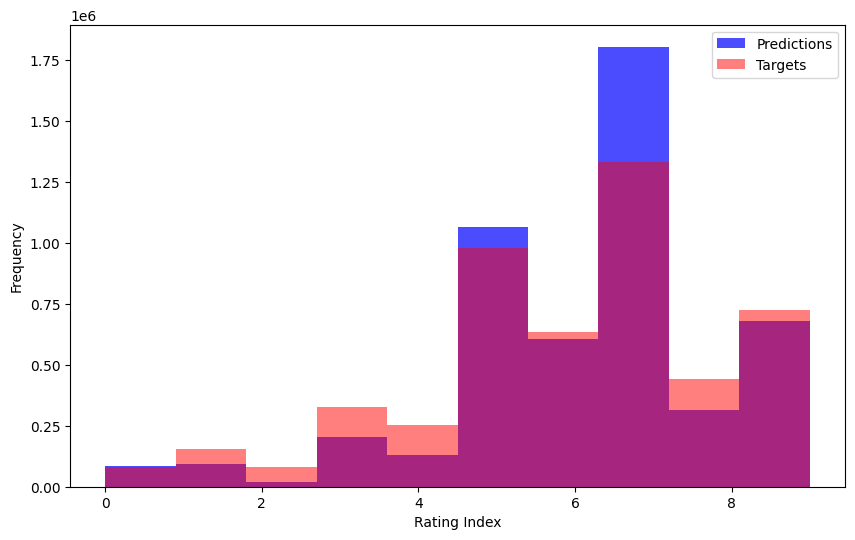

In [12]:
plt.figure(figsize=(10, 6))
plt.hist(preds.argmax(dim=1).squeeze(), alpha=0.7, color='blue', label='Predictions');
plt.hist(targs.squeeze(), alpha=0.5, color='red', label='Targets');
plt.legend()
plt.xlabel('Rating Index')
plt.ylabel('Frequency')
plt.show()

### Random Forest with Neural Net Embeddings

The final approach I was hoping to implement was using the embeddings from the neural net to create additional columns and using them to train a random forest, as done in [this Medium post](https://towardsdatascience.com/entity-embeddings-for-ml-2387eb68e49#:~:text=2.%20Replace%20each%20categorical%20value%20with%20its%20embedding%20vector).

However, I ran into some RAM and disk space issues. To illustrate, I'll show the four `Embedding`s that the model has learned, which totals an output of 955 values.

In [13]:
learn.model.embeds

ModuleList(
  (0): Embedding(162542, 600)
  (1): Embedding(21, 9)
  (2): Embedding(9856, 276)
  (3): Embedding(841, 70)
)

The smallest data type (without receiving an error) I was able to use when passing a column of `xs` through an `Embedding` was `int32` which takes up 4 bytes per element. With 20M rows in the training set, outputting 955 values each 4 bytes large would take up about 76 GB of storage.

In [1]:
20e6*4*955/1e9

76.4

Another 5M rows of the validation set (each with 955 `Embedding` outputs) would bump that up to over 100GB. Kaggle provides 73GB of disk space and 30GB of RAM. Google Colab provides 107GB of disk space and 13GB of RAM.

Handling these sorts of RAM/disk space issues is something I want to learn about and experiment with in the future, after which I can return to this scale of a dataset in an attempt to train it.

## Final Thoughts

Training models on the full MovieLens 25M rating dataset using Kaggle and/or Google Colab was _tough_. Training a single model took up to 9 hours (in the case of `DotProductBias`), so just getting through five different architectures required patience (on top of a lot of runtime crashes due to RAM maxing out). However, it was still fun to see how these different architectures behaved and performed during training. Here's a summary of my results:


|Arch|Metric|Metric Value|
|:-:|:-:|:-:|
|`DotProductBias`|MSE|0.654875
|`DotProductBiasCE`|Accuracy|35%
|Random Forest (baseline)|Accuracy|29%
|Random Forest (additional columns)|Accuracy|30%|
|Neural Net|Accuracy|38%

In the fastai textbook, the MSE of `DotProductBias` on the 100k rating subset was about 0.8 and in my experiments with `DotProductBiasCE` (Cross-Entropy Loss) the Accuracy for `DotProductBiasCE` was about 40%. The 25M `DotProductBias` beat the 100k subset's MSE and the 25M neural net was competitive with the 100k subset's accuracy.

There's still performance gains that I didn't pursue (for example, training the neural net for more epochs or trying a different number of hidden layer sizes), but I'm satisfied with the breadth of my experiments and learning experience.

I hope you enjoyed this blog post! Following me on Twitter [@vishal_learner](https://www.twitter.com/vishal_learner).